# Test ST notebook for XFEL based on Robust Speckle tracking
- https://robust-speckle-tracking.readthedocs.io/en/latest/
- uses the environment with pyrost and extra_data, extra_geom installed
- creates hdf5 files with the assembled image based on the geom file (using the code from Chufeng)
- uses multiprocessing for reading the data (much faster now)
- averaging over several frames is possible (also averages respective motor positions from the log).

In [1]:
import numpy as np
import os
import glob
import h5py
import hdf5plugin
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pyrost as rst
import pandas as pd
# import os
from extra_data import open_run, stack_detector_data
# from extra_geom import JUNGFRAUGeometry
from tqdm.notebook import trange

# from CFL
from CBD_detector_Jungfrau_utils0 import read_train, get_3d_stack_from_train_ind

from multiprocessing import Pool
from itertools import repeat
import time

In [2]:
# writing virtual cxi file
#!extra-data-make-virtual-cxi /gpfs/exfel/exp/SPB/202302/p004456/proc/r0010 -o /gpfs/exfel/exp/SPB/202302/p004456/scratch/vds/r0010.cxi

In [3]:
prop_nr = 4456
run_nr = 10
run = open_run(prop_nr, run_nr)
# run.info()

In [25]:
# # setting up the averaging for avg_nr frames 
avg = True # set False to not use averaging
avg_nr = 5 # only input if avg=True

# geometry file
current_geom = '/gpfs/exfel/exp/XMPL/201750/p700000/proc/r0040/j4m-p2805_v03.geom'

# settings for reading the data 
chunk_size = 10 # how many files are read at once, could be just 1
chunk_nr = 10 # how many chunks of data with size chunk size are read. Can be set to the number of frames 

train_ind_tuples = [(chunk_size*i, chunk_size*(i+1),1) for i in range(0,chunk_nr)]

with Pool(50) as p:
    t1 = time.time()
    #listing = np.array(p.starmap(STXM, zip(names, repeat(scanpath)))) 
    listing = p.starmap(get_3d_stack_from_train_ind, zip(repeat(prop_nr), repeat(run_nr), 
                                                         train_ind_tuples, repeat(current_geom), repeat('True')))
    #listing = p.starmap(STXM, zip(names, repeat(n)))
    t2 = time.time()
    t_diff = t2 - t1
print("Reading data in " + str(len(train_ind_tuples)) + " chunks took " + str(t_diff) + " seconds.")

t3 = time.time()

list_of_chunks = [np.array(listing[i]['stack_arry_img_adc'])[:,0,:,:] for i in range(0,chunk_nr)]
# if needs masking: also read 'stack_arry_img_mask'
image_array = np.concatenate((list_of_chunks),axis=0)

t4 = time.time()

print(f'Concatenating takes {t4-t3} seconds')

Reading data in 10 chunks took 22.860584497451782 seconds.
Concatenating takes 2.150818347930908 seconds


In [26]:
# check if the shape is as expected
image_array.shape

(100, 2164, 2234)

In [27]:
if avg: 
    out_shape = (image_array.shape[0] // avg_nr, image_array.shape[1], image_array.shape[2])
    out_array = np.zeros(out_shape)
    # Iterate over chunks of frames and accumulate mean values
    for i in range(0, image_array.shape[0] // avg_nr * avg_nr, avg_nr):
        chunk = image_array[i:i + avg_nr]
        mean_chunk = np.mean(chunk, axis=0)
        out_array[i // avg_nr] = mean_chunk
else: 
    out_array = image_array

print("Original shape:", image_array.shape)
print("Averaged shape:", out_array.shape)
    
# currently saved to scratch
output_file_path = f'/gpfs/exfel/exp/SPB/202302/p004456/scratch/st_test/assembled_run_{run_nr}.hdf5'
with h5py.File(output_file_path, 'w') as output_file:
    output_file.create_dataset('/entry/data/data', data=out_array)
print(f'Saved to {output_file_path}')

Original shape: (100, 2164, 2234)
Averaged shape: (20, 2164, 2234)
Saved to /gpfs/exfel/exp/SPB/202302/p004456/scratch/st_test/assembled_run_10.hdf5


In [28]:
!h5ls -r /gpfs/exfel/exp/SPB/202302/p004456/scratch/st_test/assembled_run_10.hdf5

/                        Group
/entry                   Group
/entry/data              Group
/entry/data/data         Dataset {20, 2164, 2234}


In [29]:
data_file = output_file_path#'/gpfs/exfel/exp/SPB/202302/p004456/scratch/st_test/assembled_run_10.hdf5'
protocol = rst.CXIProtocol.import_default()

with h5py.File(data_file) as cxi_file:
    cxi_path = protocol.find_path('data', cxi_file)
    print(cxi_path)
    print(rst.CXIProtocol.read_dataset_shapes(cxi_path, cxi_file))

/entry/data/data
{'/entry/data/data': (20, 2164, 2234)}


In [30]:
# Creating a file handler for the file

cxi_file = rst.CXIStore(data_file, 'r')

# Printing all the data attributes stored in the file

print(list(cxi_file))

# Printing a list of frame indices stored in the file

print(cxi_file.indices())

['data']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [31]:
# loading the data

with rst.CXIStore(data_file) as cxi_file:
    data = cxi_file.load_attribute('data', processes=8, verbose=True)

Loading data:   0%|          | 0/20 [00:00<?, ?it/s]

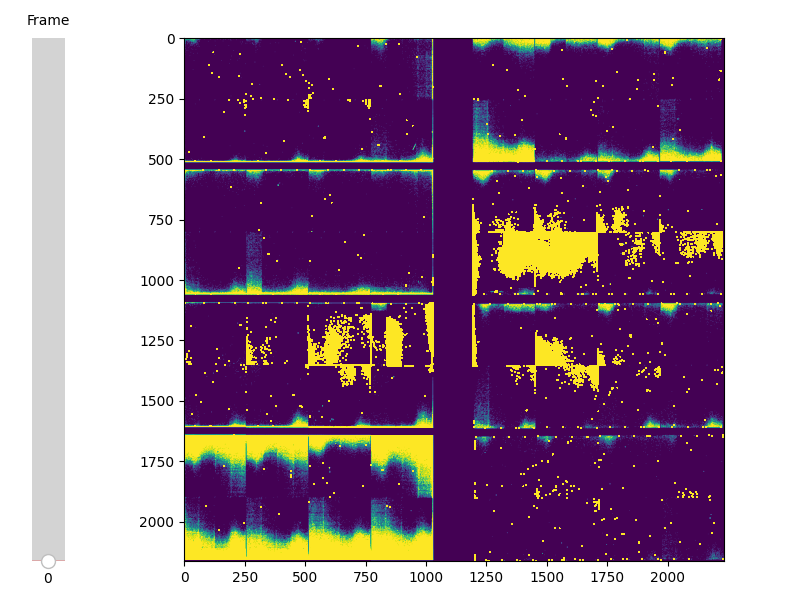

In [32]:
%matplotlib widget
fig, ax = plt.subplots(1, 2, figsize=(8, 6), gridspec_kw={'width_ratios': [0.1, 1.0]})

slider = Slider(ax=ax[0], label='Frame', valmin=0, valmax=19,
                valstep=np.arange(0, 20),
                valinit=0, orientation="vertical")

im0 = ax[1].imshow(data[0], vmin=0, vmax=1)

def update(event):
    im0.set_data(data[slider.val])
    fig.canvas.draw_idle()

slider.on_changed(update)

fig.tight_layout()

plt.show()

## Logdata

In [33]:
run = open_run(prop_nr, run_nr)
sam_x = run['SPB_IRU_SACT/MOTOR/CHAN0', 'actualPosition'].xarray()
sam_y = run['SPB_IRU_SACT/MOTOR/CHAN1', 'actualPosition'].xarray()

In [34]:
# %matplotlib widget
# fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(sam_x.trainId.values, sam_x.values, 'o', label='sam-x')
# ax.plot(sam_x.trainId.values, sam_y.values, 'o',label='sam-y')
# ax.set_xlabel('TrainID')
# ax.set_ylabel('position (mm)')
# ax.legend()

In [35]:
# probably unnecessary - sorting by trainID values
df_log_x = pd.DataFrame({'trainID': sam_x.trainId.values, 'CHAN0': sam_x.values})
df_log_y = pd.DataFrame({'trainID': sam_y.trainId.values, 'CHAN1': sam_y.values})

df_full_log = pd.merge(df_log_x, df_log_y, on='trainID', how='outer')
df_full_log

,trainID,CHAN0,CHAN1
0,1852107820,-0.000002,-1.014940
1,1852107821,-0.000002,-1.014940
2,1852107822,-0.000002,-1.014940
3,1852107823,-0.000002,-1.014940
4,1852107824,-0.000002,-1.014940
...,...,...,...
258,1852108078,-0.000001,-0.200675
259,1852108079,-0.000001,-0.200675
260,1852108080,-0.000001,-0.200675
261,1852108081,-0.000001,-0.200675


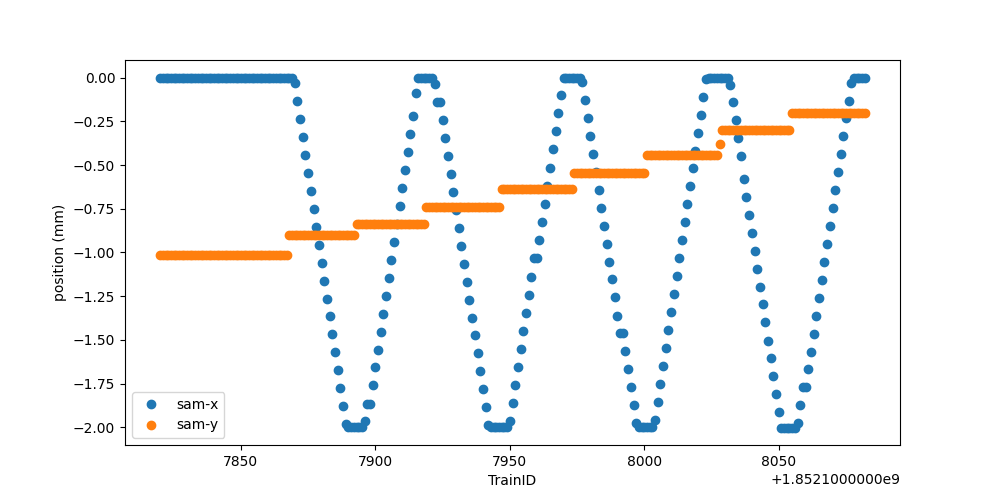

In [75]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_full_log['trainID'], df_full_log['CHAN0'], 'o',label='sam-x')
ax.plot(df_full_log['trainID'], df_full_log['CHAN1'], 'o',label='sam-y')
ax.set_xlabel('TrainID')
ax.set_ylabel('position (mm)')
ax.legend()

In [37]:
unique_pairs = df_full_log[['CHAN0', 'CHAN0']].drop_duplicates()
len(unique_pairs)

167

Text(0, 0.5, 'SAM-Y / CHAN 1')

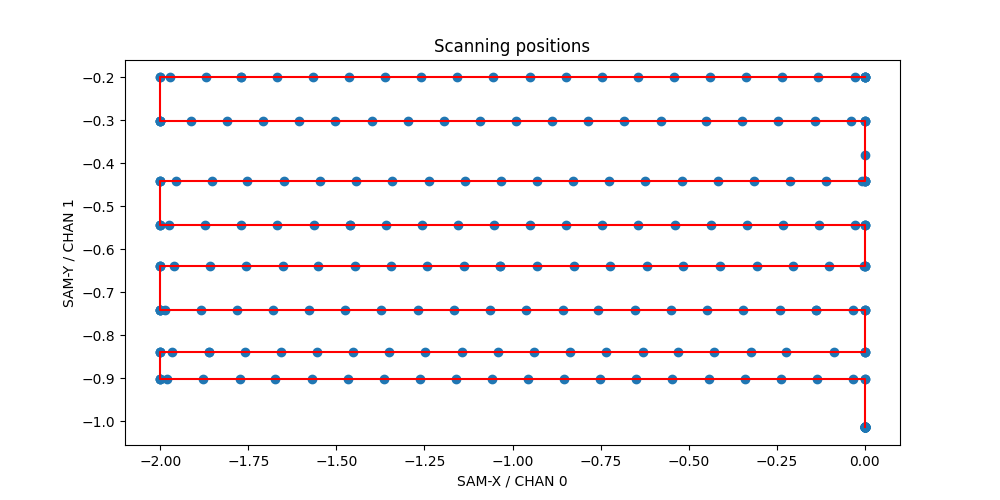

In [38]:
# check motor positions grid x,y
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Scanning positions')
ax.scatter(df_full_log.CHAN0, df_full_log.CHAN1)
ax.plot(df_full_log.CHAN0, df_full_log.CHAN1, color='red')
ax.set_xlabel('SAM-X / CHAN 0')
ax.set_ylabel('SAM-Y / CHAN 1')

In [39]:
# this ensures to use only the motor positions for the frames that are read out
N = int(chunk_size*chunk_nr) 
df_log = df_full_log.head(N)

# simulate the log structure for pyrost
sim_log = {'x_pixel_size': 7.5e-05, 'y_pixel_size': 7.5e-05, 'basis_vectors': None, 'translations' : None}

fs_vec = np.array([-75e-6, 0., 0.])
ss_vec = np.array([0., -75e-6, 0.])
cell = np.stack([ss_vec, fs_vec])

z = 0 #z0 could probably also be read from the log, but doesn't really matter


if avg:
    # if we average frames, we also need to average the positions in the log to correctly match them with frames
    df_log = df_log.groupby(np.arange(len(df_log)) // avg_nr).mean()
    n = image_array.shape[0] // avg_nr
else: 
    n = N

basis_vectors = np.tile(cell,(n,1,1))

sim_log['basis_vectors'] = basis_vectors
    
fill_array = np.zeros([n, 3])


for i in range(0,n):
    # 1e-3 because the values in the xfel logfile are in mm
    x = df_log['CHAN0'][i]*1e-3
    y = df_log['CHAN1'][i]*1e-3
    fill_array[i,:] = np.array([x,y,z])
sim_log['translations'] = fill_array

In [40]:
sim_log['translations'].shape

(20, 3)

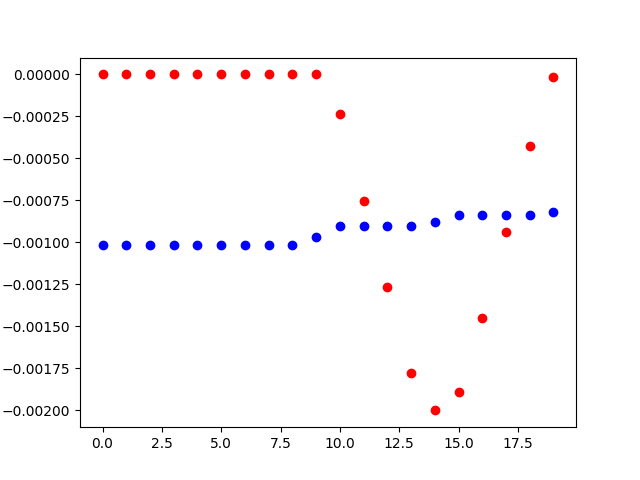

In [41]:
fig, ax = plt.subplots()
ax.plot(sim_log['translations'][:, 0], 'o', color='red')
ax.plot(sim_log['translations'][:, 1], 'o', color='blue')

# Cropping and processing

In [55]:
# roi for the full pupil
roi = (1000, 2000, 1000, 2000) # y_min, y_max, x_min, x_max 

# roi = (2400, 3150, 2410, 3200)

transform = rst.ComposeTransforms((rst.Crop(roi), rst.Downscale(2))) # change to 1 for correct wavefront size

In [56]:
distance = 1 # meters
en_to_wl = 12398.419297617678e-10 # h * c / e [eV * m]
wavelength = en_to_wl / 17.5e3

# Creating the main ST dataset container

st_data = rst.STData(input_file=rst.CXIStore(data_file, 'r'), transform=transform, **sim_log,
                     distance=distance, wavelength=wavelength)

In [57]:
# Loading detector data from the st_data.input_file

st_data = st_data.load('data', processes=8)

Loading data:   0%|          | 0/20 [00:00<?, ?it/s]

In [58]:
st_data = st_data.update_mask(method='range-bad', vmax=1000000)

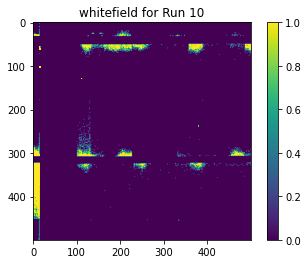

In [63]:
fig, ax = plt.subplots()
im = ax.imshow(st_data.whitefield, vmin=0, vmax = 1)
ax.set_title(f'whitefield for Run {run_nr}')
plt.colorbar(im, ax = ax)

In [60]:
st_data = st_data.mask_frames()

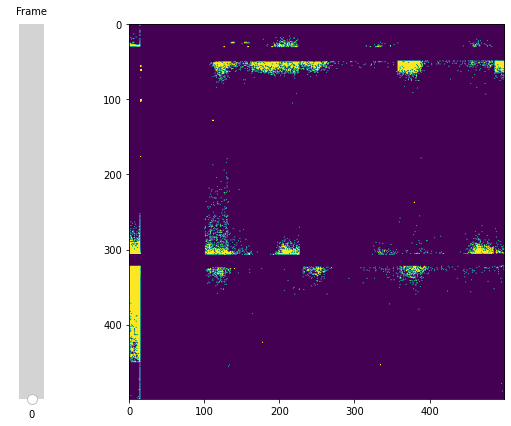

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6), gridspec_kw={'width_ratios': [0.1, 1.0]})

slider = Slider(ax=ax[0], label='Frame', valmin=0, valmax=19,
                valstep=np.arange(0, 20),
                valinit=0, orientation="vertical")

im0 = ax[1].imshow(st_data.data[0] * st_data.mask[0], vmin=0, vmax=1)

def update(event):
    im0.set_data(st_data.data[slider.val] * st_data.mask[slider.val])
    fig.canvas.draw_idle()

slider.on_changed(update)

fig.tight_layout()
plt.show()

## Finding defocus

In [62]:
defoci_x = np.linspace(560e-6, 1600e-6, 10)
defoci_y = np.linspace(560e-6, 1600e-6, 10)

defoci_x, defoci_y = np.meshgrid(defoci_x, defoci_y)

# sweep_scan is the figure of merit of sharpness, it's maximised at the correct defocus distance
# size - the size of the local standard deviation filter,
#        the higher it is the lower spatial frequencies you take into account
# ds_x, ds_y - sampling intervals of the reference image in pixels
# hval - kernel bandwidth used in the reference image reconstruction,
#        the higher it is the blurrier the image is

sweep_scan, extra = st_data.defocus_sweep(defoci_x, defoci_y, size=50, hval=1.0,
                                          extra_args={'ds_x': 3.0, 'ds_y': 3.0},
                                          return_extra=True, verbose=True)

Generating defocus sweep:   0%|          | 0/100 [00:00<?, ?it/s]

In [64]:
# reshaping the R-values into an image

sweep_scan = np.array(sweep_scan).reshape(defoci_x.shape)

In [65]:
# Finding the optimal defoci

index = np.unravel_index(np.argmax(sweep_scan), defoci_x.shape)
defocus_x, defocus_y = defoci_x[index], defoci_y[index]
print(defocus_x*1e6, defocus_y*1e6)

1600.0 1600.0


In [66]:
# %matplotlib widget
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.imshow(sweep_scan)
# fig.tight_layout()
# plt.show()

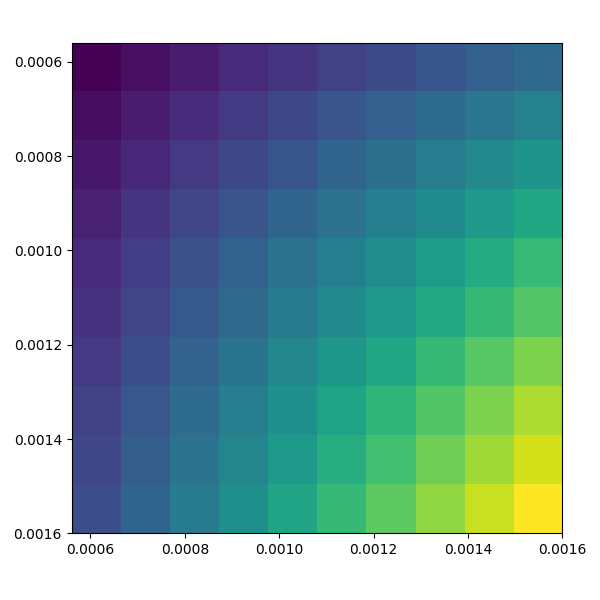

In [67]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(sweep_scan, extent=[defoci_x.min(), defoci_x.max(),
                              defoci_y.max(), defoci_y.min()])
fig.tight_layout()
plt.show()

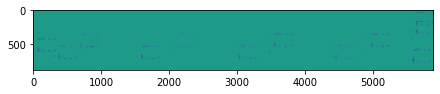

In [68]:
# plotting the reference image corresponding to the optimal defocus distance
# for the test data it is not informative of course

%matplotlib inline
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout = True)
ax.imshow(extra['reference_image'][np.argmax(sweep_scan)], vmin=0.4, vmax=1.5)
# ax.set_title(f'Run {run_nr}, reference image')
# plt.savefig(f'results/Scan_{scan_num}_ref_image_auto.png', bbox_inches = 'tight', dpi=100)
plt.show()

In [69]:
# parsing the found defoci to the ST data container

st_data = st_data.update_defocus(defocus_x, defocus_y)


### 4. Performing iterative PXST reconstruction

pyrost.SpeckleTracking provides an interface to iteratively refine the reference image and lens wavefront.
It offers two methods to choose from:

* `pyrost.SpeckleTracking.train` : performs the iterative reference image
  and pixel mapping updates with the constant kernel bandwidths for the reference image
  estimator (`h0`).

* `pyrost.SpeckleTracking.train_adapt` : does ditto, but updates the bandwidth
  value for the reference image estimator at each iteration by the help of the BFGS method
  to attain the minimal error value.

In [70]:
# generating a speckle tracking "reconstructer"
# ds_x, ds_y - sampling intervals of the reference image in pixels

st_obj = st_data.get_st(ds_x=5.0, ds_y=5.0)

In [71]:
# finding the optimal reference image bandwidth
#
# kernel bandwidth used in the reference image reconstruction,
# the higher it is the blurrier the image is
#
# The cross validation error is minimized when the kernel bandwidth is "right"
# CV -> https://towardsdatascience.com/what-is-cross-validation-60c01f9d9e75

h_vals = np.linspace(0.5, 3.0, 25)
cv_vals = st_obj.CV_curve(h_vals)

Calculating CV:   0%|          | 0/25 [00:00<?, ?it/s]

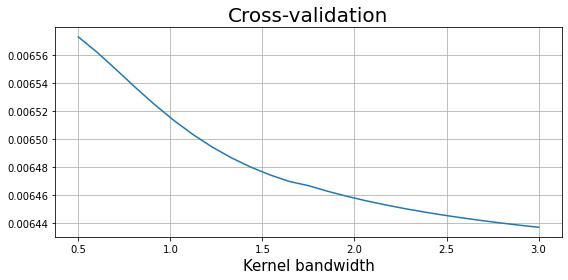

In [72]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(h_vals, cv_vals)
ax.set_xlabel('Kernel bandwidth', fontsize=15)
ax.set_title('Cross-validation', fontsize=20)
ax.tick_params(labelsize=10)
ax.grid(True)
fig.tight_layout()
plt.show()

#### Performing the reconstruction

`pyrost.SpeckleTracking` provides an interface to perform the reference image and lens wavefront
reconstruction and offers two methods:

1. **`pyrost.SpeckleTracking.train`** - iterative update with the static bandwidth
2. **`pyrost.SpeckleTracking.train_adapt`** - iterative update with the adpatively updated bandwidth

The typical reconstruction cycle consists of:

* Estimating an optimal kernel bandwidth for the reference image estimate (`pyrost.SpeckleTracking.find_hopt`,
  in `pyrost.SpeckleTracking.train_adapt` only).
* Generating the reference image (`pyrost.SpeckleTracking.update_reference`).
* Updating the discrete (pixel) mapping between a stack of frames and the generated reference image
  (`pyrost.SpeckleTracking.update_pixel_map`).
* Updating the sample translations vectors (`pyrost.SpeckleTracking.update_translations`).
* Calculating figures of merit (`pyrost.SpeckleTracking.ref_total_error`,
  `pyrost.SpeckleTracking.error_profile`).
  
`pyrost.SpeckleTracking.train_adapt` parameters:
- `search_window` : A tuple of three elements ('sw_y', 'sw_x', 'sw_s'). The elements are the following:

    * `sw_y` : Search window size in pixels along the horizontal detector axis.
    * `sw_x` : Search window size in pixels along the vertical detector axis.
    * `sw_s` : Search window size of the Huber scaling map. Given as a ratio (0.0 - 1.0) relative to the scaling map value before the update.

- `h0` : Initial kernel bandwidth used in `reference_image` estimation. The value is given in pixels.
- `blur` : Smoothing kernel bandwidth used in `pixel_map` regularisation. The value is given in pixels.
- `n_iter` : Maximum number of iterations.

In [74]:
h0 = h_vals[np.argmin(cv_vals)]

# performing the PXST reconstruction with adaptive bandwidth
# performing the update first with high 'blur' value to supress any artifacts in pixel_map

# more info -> https://robust-speckle-tracking.readthedocs.io/en/latest/reference/rst_ref.html

st_adapt = st_obj.train_adapt(search_window=(5.0, 5.0, 0.1), h0=h0, blur=50.0,  n_iter=10,
                              pm_method='rsearch', pm_args={'n_trials': 50}) # f_tol = -1 n_iter=10

   0%            Iteration 0 / 10 [00:00<?, ?it/s]

Initial error = 0.031989, Initial h0 = 3.00


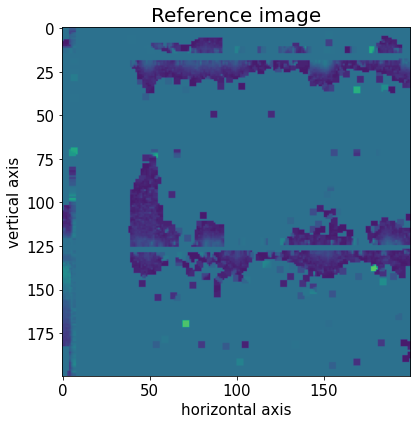

In [82]:

fig, ax = plt.subplots(figsize=(7, 6))
ax.imshow(st_adapt.reference_image, vmin=0.4, vmax=2.0)
ax.set_title('Reference image', fontsize=20)
ax.set_xlabel('horizontal axis', fontsize=15)
ax.set_ylabel('vertical axis', fontsize=15)
ax.tick_params(labelsize=15)
# plt.savefig(f'results/Scan_{scan_num}_ref_image_refined_0.png', bbox_inches = 'tight', dpi=100)
fig.tight_layout()
plt.show()

In [83]:
# performing the fine update with lower 'blur' value

st_adapt = st_adapt.train_adapt(search_window=(5.0, 5.0, 0.1), h0=h0, blur=20.0, n_iter=10,
                                pm_method='rsearch', pm_args={'n_trials': 75})

   0%            Iteration 0 / 10 [00:00<?, ?it/s]

Initial error = 0.026771, Initial h0 = 1.85


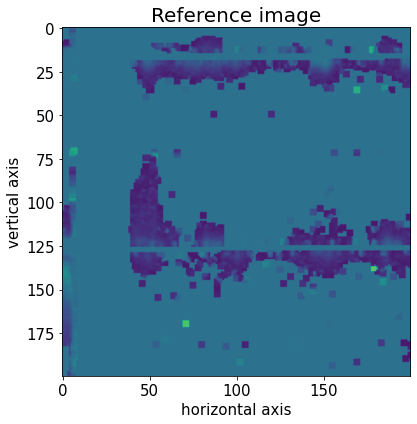

In [84]:
# Plotting the reconstructed reference image
# All the blurriness has to be corrected after the update

fig, ax = plt.subplots(figsize=(7, 6))
ax.imshow(st_adapt.reference_image, vmin=0.4, vmax=2.0)
ax.set_title('Reference image', fontsize=20)
ax.set_xlabel('horizontal axis', fontsize=15)
ax.set_ylabel('vertical axis', fontsize=15)
ax.tick_params(labelsize=15)
# plt.savefig(f'results/Scan_{scan_num}_ref_image_refined_1.png', bbox_inches = 'tight', dpi=100)
fig.tight_layout()
plt.show()

In [ ]:
np.shape(st_adapt.reference_image)

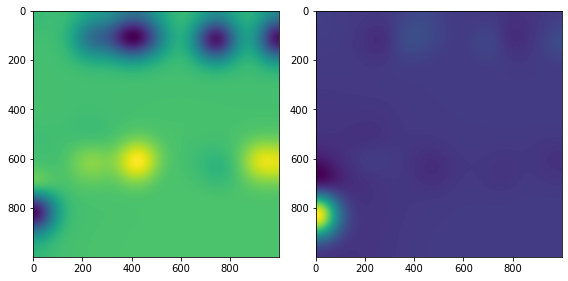

In [86]:
# Plotting the reconstructed pixel_map
# You expect to see a smooth profile with following the third polynomial

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow((st_adapt.pixel_map[0] - st_obj.pixel_map[0]))
ax[1].imshow((st_adapt.pixel_map[1] - st_obj.pixel_map[1]))
fig.tight_layout()
plt.show()

### 4. Phase reconstruction

We got the pixel mapping from the detector plane to the reference plane, which can
be easily translated to the angular displacement profile of the lens. One can reconstruct
the lens' phase profile with `pyrost.STData.import_st` method. Besides, one can fit the phase
profile with a polynomial function using `pyrost.AberrationsFit` fitter object,
which can be obtained with `pyrost.STData.get_fit` method.

In [87]:
# Generating a phase out of st_adapt.pixel_map
# The phase is saved into st_data.phase

st_data.import_st(st_adapt)

In [88]:
# Fitting the phase profile with st_data.get_fit
# axis - 0 for y axis and 1 for x axis

fit_obj_ss = st_data.get_fit(axis=0)
fit_ss = fit_obj_ss.fit(max_order=3)
fit_obj_fs = st_data.get_fit(axis=1)
fit_fs = fit_obj_fs.fit(max_order=3)
print(fit_fs['c_3'], fit_fs['c_4'], fit_ss['c_3'], fit_ss['c_4'])

0.00040989801839327736 -2.3594022223722304e-06 -0.00041101192434314746 1.0851442376550543e-06


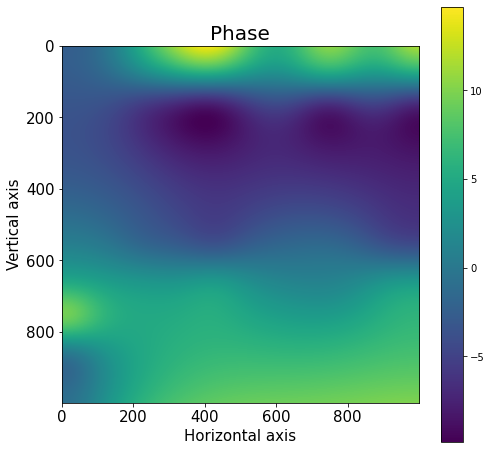

In [89]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(st_data.get('phase'))
ax.set_title('Phase', fontsize=20)
ax.set_xlabel('Horizontal axis', fontsize=15)
ax.set_ylabel('Vertical axis', fontsize=15)
ax.tick_params(labelsize=15)
plt.colorbar(im, ax=ax)
plt.show()

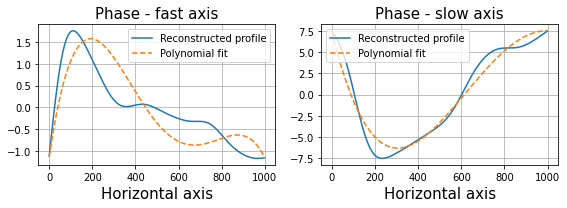

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(fit_obj_fs.pixels, fit_obj_fs.phase, label='Reconstructed profile')
axes[0].plot(fit_obj_fs.pixels, fit_obj_fs.model(fit_fs['ph_fit']), linestyle='dashed',
                 label='Polynomial fit')
axes[0].set_xlabel('Horizontal axis', fontsize=15)
axes[1].plot(fit_obj_ss.pixels, fit_obj_ss.phase, label='Reconstructed profile')
axes[1].plot(fit_obj_ss.pixels, fit_obj_ss.model(fit_ss['ph_fit']), linestyle='dashed',
             label='Polynomial fit')
axes[1].set_xlabel('Horizontal axis', fontsize=15)
for ax in axes:
#     ax.set_title('Phase', fontsize=15)
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=10)
    ax.grid(True)
axes[0].set_title('Phase - fast axis', fontsize=15)
axes[1].set_title('Phase - slow axis', fontsize=15)
fig.tight_layout()
plt.show()

In [91]:
defocus_x, defocus_y

(0.0002977777777777778, 0.0002977777777777778)

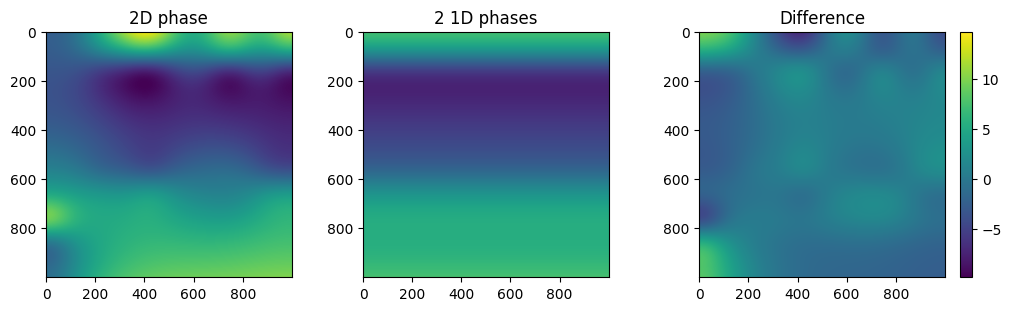

In [92]:
%matplotlib inline

phase_2d = st_data.get('phase')

phase_x = np.average(phase_2d, axis = 1)
phase_y = np.average(phase_2d, axis = 0)

phase_2d_ideal = np.zeros(phase_2d.shape)

for i in range(phase_2d_ideal.shape[0]):
    for j in range(phase_2d_ideal.shape[1]):
        phase_2d_ideal[i,j] = phase_x[i] + phase_y[j]

fig,ax = plt.subplots(nrows = 1, ncols = 3, figsize=(10,3), dpi=100, constrained_layout=True)
min_counts = phase_2d.min()
max_counts = phase_2d.max()

ax[0].imshow(phase_2d, vmin=min_counts, vmax = max_counts)
ax[0].set_title('2D phase')

ax[1].imshow(phase_2d_ideal, vmin=min_counts, vmax = max_counts)
ax[1].set_title('2 1D phases')

im = ax[2].imshow(phase_2d_ideal- phase_2d, vmin=min_counts, vmax = max_counts)
ax[2].set_title('Difference')

plt.colorbar(im, ax=ax[2])

In [939]:
# # Creating an output file test.h5

# output_file = rst.CXIStore('test.h5', 'a')

# # Parsing the file to the ST data container

# st_data = st_data.update_output_file(output_file)

# # Saving the results into the file

# st_data.save(mode='overwrite')

In [75]:
# !h5ls -r test.h5